In [ ]:
import argparse
import sys
import os

import random

import time
import datetime

from collections import Counter
import numpy as np

import shutil
import inspect

import gc

import re

import keras
from keras import models
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, BatchNormalization
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras import backend as K

import tensorflow as tf

from IPython.display import display
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix



In [50]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

In [ ]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==2:    
        print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
    if x==3:  
        print('Date now: %s' % datetime.datetime.now())
    if x==4:  
        print('Date today: %s' % datetime.date.today())  

In [ ]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

In [ ]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [ ]:
def get_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #     x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(2, activation='softmax')(x) 

    model = Model(inputs=base_model.input, outputs=predictions)


    for layer in base_model.layers:
        layer.trainable = False
        
    
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True

    model.summary()
    
    return model


In [ ]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    try:
        del model
    except:
        return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint=None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

In [1]:
reset_graph(model)
reset_callbacks()

NameError: name 'reset_graph' is not defined

In [11]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory+ r"train"
validation_dir = input_directory+ r"val"
testing_dir = input_directory+ r"test"

classes = os.listdir(training_dir)
classes = ['NORMAL', 'PNEUMONIA']
classes

['NORMAL', 'PNEUMONIA']

In [12]:
target_size = (299,299)
# target_size = (150,150)

rescale=1./255.0
# batch_size = 32

batch_size = 32


class_mode='categorical'

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale)     

train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size)


validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size)    

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [13]:
# from sklearn.utils import class_weight

# class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
# class_weight

In [14]:
#--------------------------------------------------------------------------------------------------------------------#
# Model Directory
#--------------------------------------------------------------------------------------------------------------------#
model_dir=output_directory + r"models/"+time.strftime('%Y-%m-%d %H-%M-%S')+"/"
# model_dir=output_directory + r"models/"+time.strftime('%Y%m%d%H%M%S')+"/"
#--------------------------------------------------------------------------------------------------------------------#
# Log Directory
#--------------------------------------------------------------------------------------------------------------------#
# log_dir=output_directory + r"logs/"+time.strftime('%Y%m%d%H%M%S')
log_dir=output_directory + r"logs/"+time.strftime('%Y-%m-%d %H-%M-%S')
#--------------------------------------------------------------------------------------------------------------------#



# Create Output Directory (Model and Log)
#--------------------------------------------------------------------------------------------------------------------#
create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)
#--------------------------------------------------------------------------------------------------------------------#


#--------------------------------------------------------------------------------------------------------------------#
# Model File Name Configuration
#------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Initial Trainning Model Filename 
#----------------------------------------------------------------------------------------------------#
init_model_file=model_dir+"base-"+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Trainning Model Filename 
#----------------------------------------------------------------------------------------------------#
model_file=model_dir+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------------------------------#
# Retrainning Model Filename 
#----------------------------------------------------------------------------------------------------#
retrain_model_file=model_dir+"retrain-{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
#--------------------------------------------------------------------------------------------------------------------#

In [15]:
reset_graph(model)

True

In [16]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_loss',
    save_best_only=True, 
    save_weights_only=False)


early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size)


reduce_lr = ReduceLROnPlateau(monitor='val_loss')

In [17]:
# callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
callbacks = [checkpoint, early_stopping, tensorboard]


In [18]:
date_time(1)
model = get_model()
date_time(1)

Timestamp: 2018-12-10 13:38:42
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________________________________________________________________

In [20]:
def train(train_generator, validation_generator, epochs, callbacks):
    date_time(1)
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=len(validation_generator))
    
    date_time(1)
    
    return history

In [19]:
date_time(1)

optimizer=optimizers.Adam(0.00001)
loss='categorical_crossentropy'
metrics=['accuracy']


model.compile(optimizer, loss=loss, metrics=metrics)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=100,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

date_time(1)


Timestamp: 2018-12-10 13:38:58
Epoch 1/100
163/163 [==============================] - 270s 2s/step - loss: 0.4655 - acc: 0.8021 - val_loss: 0.7070 - val_acc: 0.6687
Epoch 2/100
163/163 [==============================] - 210s 1s/step - loss: 0.2922 - acc: 0.9038 - val_loss: 0.9351 - val_acc: 0.5875
Epoch 3/100
163/163 [==============================] - 204s 1s/step - loss: 0.2428 - acc: 0.9285 - val_loss: 0.5532 - val_acc: 0.7375
Epoch 4/100
163/163 [==============================] - 196s 1s/step - loss: 0.2042 - acc: 0.9381 - val_loss: 0.5343 - val_acc: 0.7500
Epoch 5/100
163/163 [==============================] - 192s 1s/step - loss: 0.1718 - acc: 0.9471 - val_loss: 0.4812 - val_acc: 0.7812
Epoch 6/100
163/163 [==============================] - 190s 1s/step - loss: 0.1611 - acc: 0.9546 - val_loss: 0.4495 - val_acc: 0.8063
Epoch 7/100
163/163 [==============================] - 190s 1s/step - loss: 0.1531 - acc: 0.9565 - val_loss: 0.4138 - val_acc: 0.8313
Epoch 8/100
163/163 [==========

In [41]:
epochs=10
optimizer=optimizers.Adam(0.0000001)
loss='categorical_crossentropy'
metrics=['accuracy']
model.compile(optimizer, loss=loss, metrics=metrics)

train(train_generator, validation_generator, epochs)

Timestamp: 2018-12-11 02:57:58
Epoch 1/10
163/163 [==============================] - 294s 2s/step - loss: 0.0415 - acc: 0.9845 - val_loss: 0.2693 - val_acc: 0.8812
Epoch 2/10
163/163 [==============================] - 232s 1s/step - loss: 0.0430 - acc: 0.9862 - val_loss: 0.2675 - val_acc: 0.8812
Epoch 3/10
163/163 [==============================] - 218s 1s/step - loss: 0.0435 - acc: 0.9854 - val_loss: 0.2684 - val_acc: 0.8875
Epoch 4/10
163/163 [==============================] - 224s 1s/step - loss: 0.0438 - acc: 0.9849 - val_loss: 0.2712 - val_acc: 0.8844
Epoch 5/10
163/163 [==============================] - 202s 1s/step - loss: 0.0396 - acc: 0.9873 - val_loss: 0.2723 - val_acc: 0.8844
Epoch 6/10
163/163 [==============================] - 202s 1s/step - loss: 0.0444 - acc: 0.9854 - val_loss: 0.2720 - val_acc: 0.8812
Epoch 7/10
163/163 [==============================] - 200s 1s/step - loss: 0.0358 - acc: 0.9883 - val_loss: 0.2686 - val_acc: 0.8812
Epoch 8/10
163/163 [==================

In [42]:
model_dir = "data/output/models/"

dirs = os.listdir(model_dir)
for i in range(len(dirs)):
    print(i, dirs[i])

0 2018-12-08 04-35-31
1 2018-12-08 17-16-53
2 2018-12-08 19-49-27
3 2018-12-10 13-38-27


In [44]:
current_dir = model_dir+dirs[3]+"/"

print(current_dir)
cur_models = os.listdir(current_dir)
for i in range(len(cur_models)):
    print(i, cur_models[i])

data/output/models/2018-12-10 13-38-27/
0 01-val_acc-0.67-val_loss-0.71.hdf5
1 02-val_acc-0.90-val_loss-0.25.hdf5
2 03-val_acc-0.74-val_loss-0.55.hdf5
3 04-val_acc-0.75-val_loss-0.53.hdf5
4 05-val_acc-0.78-val_loss-0.48.hdf5
5 05-val_acc-0.90-val_loss-0.24.hdf5
6 06-val_acc-0.81-val_loss-0.45.hdf5
7 07-val_acc-0.83-val_loss-0.41.hdf5
8 08-val_acc-0.84-val_loss-0.39.hdf5
9 08-val_acc-0.90-val_loss-0.23.hdf5
10 09-val_acc-0.85-val_loss-0.36.hdf5
11 10-val_acc-0.84-val_loss-0.35.hdf5
12 14-val_acc-0.85-val_loss-0.34.hdf5
13 15-val_acc-0.86-val_loss-0.32.hdf5
14 25-val_acc-0.87-val_loss-0.28.hdf5
15 32-val_acc-0.89-val_loss-0.27.hdf5


In [46]:
cur_model = cur_models[9]
model_file = current_dir+cur_model
print(model_file)

data/output/models/2018-12-10 13-38-27/08-val_acc-0.90-val_loss-0.23.hdf5


In [ ]:
# validation_datagen = ImageDataGenerator(rescale=1./255)
# validation_generator = validation_datagen.flow_from_directory(
#     validation_dir,
#     target_size=target_size,
#     classes = classes,
#     class_mode=class_mode,
#     batch_size=1)

# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     testing_dir,
#     target_size=target_size,
#     classes = classes,
#     class_mode=class_mode,
#     batch_size=1)

In [ ]:
model = keras.models.load_model(model_file, custom_objects={'accuracy':'accuracy', 'precision':precision, 'recall':recall, 'f1':f1})

In [47]:
date_time(1)
# result = model.evaluate_generator(generator=test_generator, steps=100, verbose=1)
result = model.evaluate_generator(generator=test_generator, steps=len(test_generator), verbose=1)
        

Timestamp: 2018-12-11 04:54:28
320/320 [==============================] - 184s 575ms/step


In [39]:
result

[0.5935210860009021, 0.7375]

In [49]:
loss = result[0]
accuracy = result[1]*100
# precision = result[2]*100
# recall = result[3]*100
# f1_score = result[4]*100

print("%s%.2f%s"% ("Accuracy: ", accuracy, "%"))
# print("%s%.2f%s"% ("Precision: ", precision, "%"))
# print("%s%.2f%s"% ("Recall: ", recall, "%"))
# print("%s%.2f%s"% ("F1 - score: ", f1_score, "%"))
print("%s%.2f"% ("Loss: ", loss))

date_time(1)

Accuracy: 73.75%
Loss: 0.64
Timestamp: 2018-12-11 04:57:33


In [ ]:
date_time(1)

# y_preds = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_preds = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
        
y_classes = y_preds.argmax(axis=-1)
date_time(1)

Timestamp: 2018-12-11 05:11:52


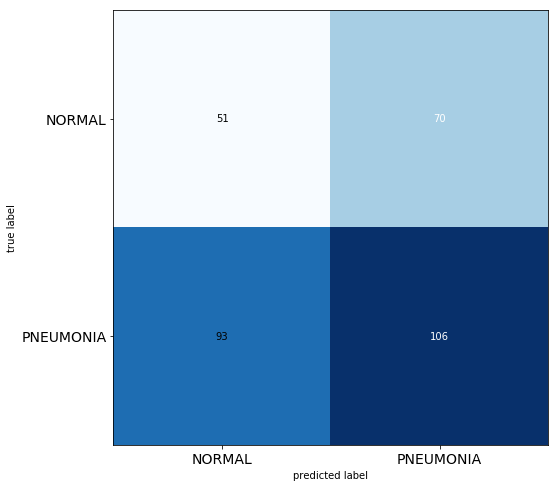

In [32]:
CM = confusion_matrix(test_generator.classes, y_classes)

fig, ax = plot_confusion_matrix(
    conf_mat=CM ,  
    figsize=(10,8), 
    hide_ticks=True,cmap=plt.cm.Blues)
# plt.title("Model File: "+cur_model)
plt.xticks(range(len(classes)), classes, fontsize=14)
plt.yticks(range(len(classes)), classes, fontsize=14)
# cm_name = "data/output/figures/CM-"+cur_model[:-5]+".png"
# print(cm_name)
# plt.savefig("data/output/figures/CM"+cur_model+".png", dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()

In [33]:
CM = confusion_matrix(test_generator.classes, y_classes)

cls_report_print = classification_report(test_generator.classes, y_classes, target_names=classes)

# cls_report = classification_report(test_generator.classes, y_classes, target_names=classes, output_dict=True)

# if print_report: 
print(cls_report_print)


              precision    recall  f1-score   support

      NORMAL       0.35      0.42      0.38       121
   PNEUMONIA       0.60      0.53      0.57       199

   micro avg       0.49      0.49      0.49       320
   macro avg       0.48      0.48      0.48       320
weighted avg       0.51      0.49      0.50       320



In [34]:
import numpy as np
from sklearn import metrics

y_true=test_generator.classes
y_pred = y_preds.argmax(-1) 

x=metrics.accuracy_score(y_true, y_pred)

x=metrics.accuracy_score(y_true, y_pred, normalize=False)

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=2)

x=metrics.auc(fpr, tpr)


x=metrics.average_precision_score(y_true, y_pred) 


x=metrics.balanced_accuracy_score(y_true, y_pred)

x=metrics.brier_score_loss(y_true, 1-y_pred, pos_label=1) 

x=metrics.f1_score(y_true, y_pred, average='micro')
print(x)
x=metrics.f1_score(y_true, y_pred, average='macro')
x=metrics.f1_score(y_true, y_pred, average='weighted')
x=metrics.f1_score(y_true, y_pred, average=None)



# x=metrics.fbeta_score(y_true, y_pred, average='macro', beta=0.5)

# x=metrics.fbeta_score(y_true, y_pred, average='micro', beta=0.5)

# x=metrics.fbeta_score(y_true, y_pred, average='weighted', beta=0.5)

# x=metrics.fbeta_score(y_true, y_pred, average=None, beta=0.5)

# x=metrics.hamming_loss(y_true, y_pred)

x=metrics.roc_auc_score(y_true, y_pred)
print(x)





0.490625
0.47707545994434986


C:\Users\Andromeda\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
